# LA Healthcare Access Mapping - Final Analysis & Results

**Complete Analysis: Phases 4-7**

This notebook completes:
- Exploratory Data Analysis
- Access Metrics Calculation
- Visualization & Mapping  
- Analysis & Insights

## Project Goals
1. Identify neighborhoods with limited access to urgent care
2. Analyze access disparities using population density, distance, and facility availability
3. Provide insights for resource allocation

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from pathlib import Path
from scipy.spatial import cKDTree
from datetime import datetime

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Paths
project_root = Path.cwd().parent
data_processed = project_root / 'data' / 'processed'
outputs_maps = project_root / 'outputs' / 'maps'
outputs_figures = project_root / 'outputs' / 'figures'
outputs_reports = project_root / 'outputs' / 'reports'

# Create output directories
outputs_maps.mkdir(parents=True, exist_ok=True)
outputs_figures.mkdir(parents=True, exist_ok=True)
outputs_reports.mkdir(parents=True, exist_ok=True)

print("✓ Environment ready")
print(f"Project root: {project_root}")

✓ Environment ready
Project root: /Users/joelnewton/Desktop/2026-Code/projects/la-healthcare-access-mapping


## Phase 4: Exploratory Data Analysis

In [2]:
# Load cleaned data
facilities = pd.read_csv(data_processed / 'facilities_cleaned_20260204.csv')
census = pd.read_csv(data_processed / 'census_tracts_data_20260204.csv')

print(f"Facilities loaded: {len(facilities)}")
print(f"Census tracts loaded: {len(census)}")
print(f"\nFacility columns: {list(facilities.columns)}")
print(f"Census columns: {list(census.columns)[:10]}...")

Facilities loaded: 4512
Census tracts loaded: 2498

Facility columns: ['lat', 'lon', 'county', 'facility_id']
Census columns: ['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'GEOIDFQ', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND']...


In [3]:
# Summary Statistics
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\n📍 HEALTHCARE FACILITIES")
print(f"Total facilities: {len(facilities):,}")
print(f"\nGeographic coverage:")
print(f"  Latitude range: {facilities['lat'].min():.4f} to {facilities['lat'].max():.4f}")
print(f"  Longitude range: {facilities['lon'].min():.4f} to {facilities['lon'].max():.4f}")

print(f"\n👥 DEMOGRAPHICS")
print(f"Total census tracts: {len(census):,}")
if 'total_population' in census.columns:
    print(f"Total LA County population: {census['total_population'].sum():,.0f}")
    print(f"Average tract population: {census['total_population'].mean():,.0f}")
    print(f"Median tract population: {census['total_population'].median():,.0f}")

if 'median_income' in census.columns:
    print(f"\n💰 INCOME")
    print(f"Median household income (county median): ${census['median_income'].median():,.0f}")
    print(f"Income range: ${census['median_income'].min():,.0f} - ${census['median_income'].max():,.0f}")

SUMMARY STATISTICS

📍 HEALTHCARE FACILITIES
Total facilities: 4,512

Geographic coverage:
  Latitude range: 33.7364 to 34.7771
  Longitude range: -118.6975 to -117.6992

👥 DEMOGRAPHICS
Total census tracts: 2,498
Total LA County population: 9,936,690
Average tract population: 3,978
Median tract population: 3,898

💰 INCOME
Median household income (county median): $81,201
Income range: $-666,666,666 - $250,001


✓ Saved: facility_distribution.png


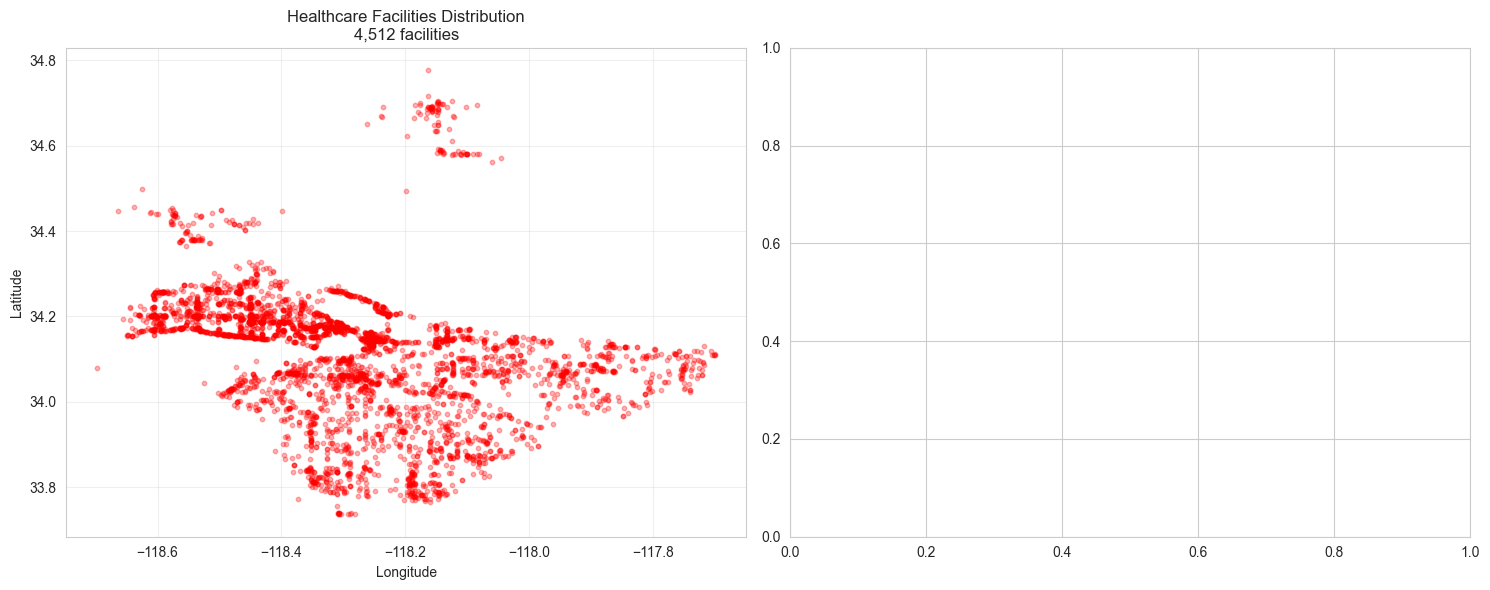

In [4]:
# Visualize facility distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Facility scatter plot
axes[0].scatter(facilities['lon'], facilities['lat'], alpha=0.3, s=10, c='red')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title(f'Healthcare Facilities Distribution\n{len(facilities):,} facilities')
axes[0].grid(True, alpha=0.3)

# Facility density histogram
if 'category' in facilities.columns:
    category_counts = facilities['category'].value_counts()
    axes[1].bar(range(len(category_counts)), category_counts.values)
    axes[1].set_xticks(range(len(category_counts)))
    axes[1].set_xticklabels(category_counts.index, rotation=45, ha='right')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Facilities by Category')
    axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(outputs_figures / 'facility_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: facility_distribution.png")
plt.show()

✓ Saved: demographic_analysis.png


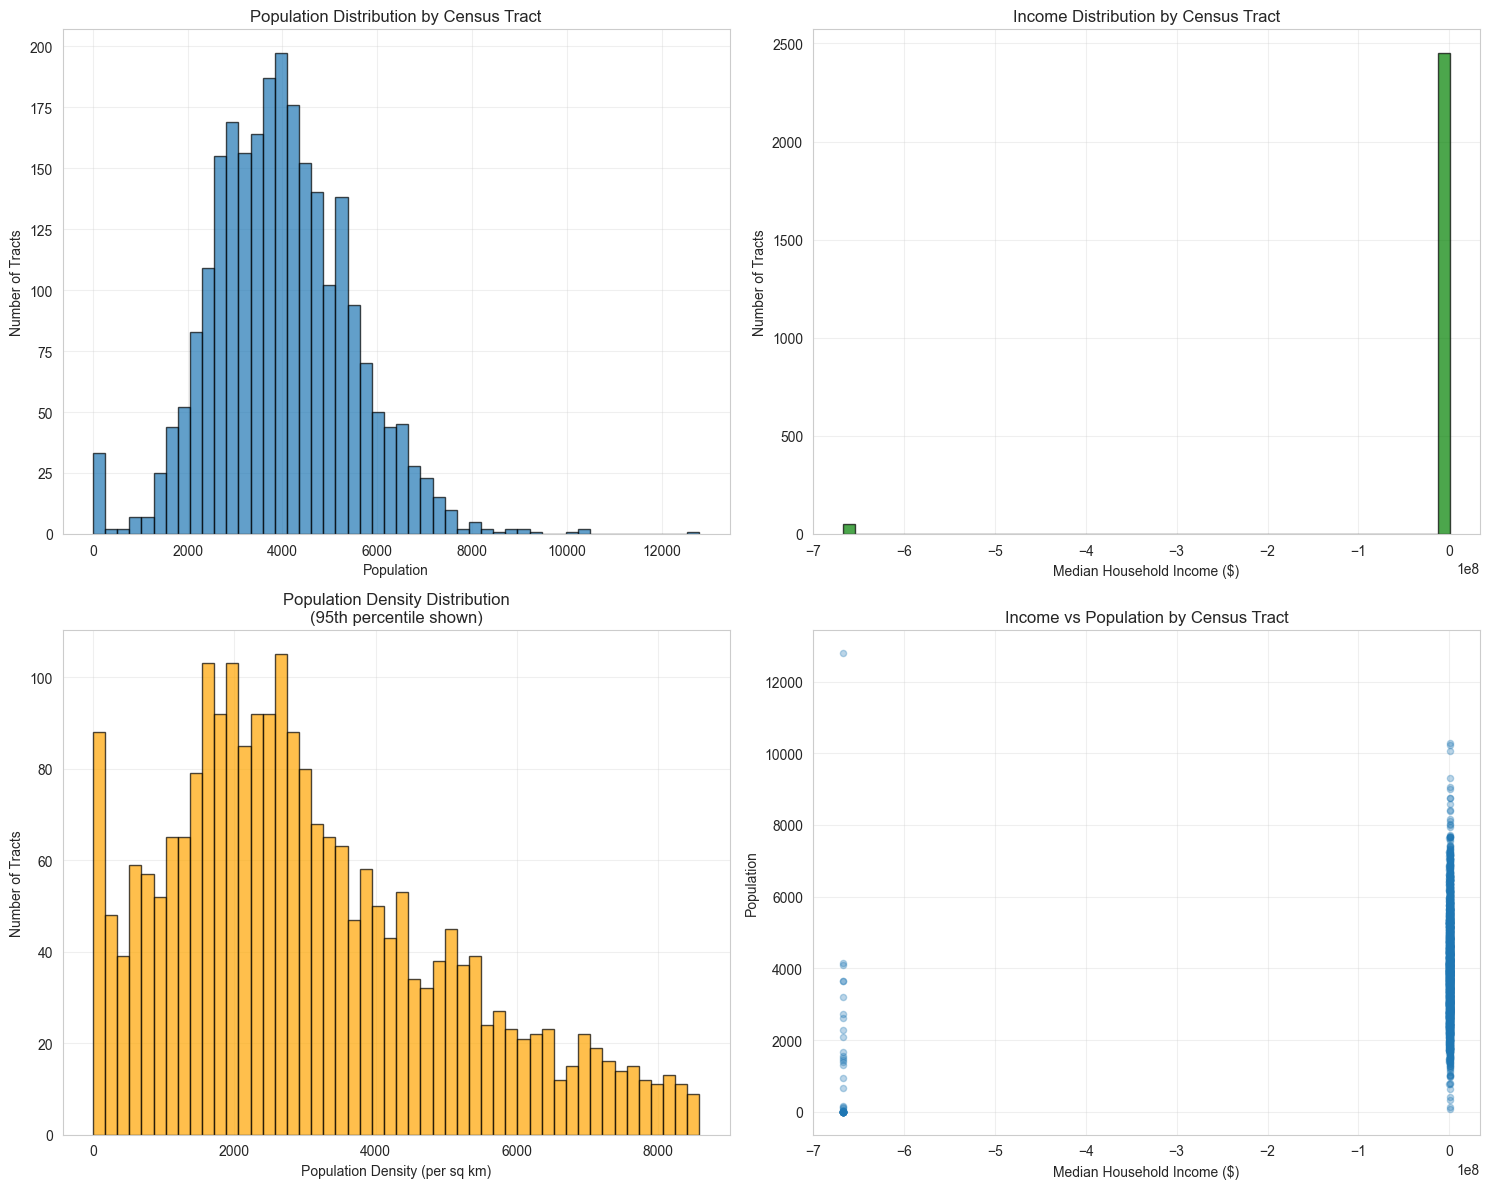

In [5]:
# Demographic visualizations
if 'total_population' in census.columns and 'median_income' in census.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Population distribution
    axes[0,0].hist(census['total_population'], bins=50, edgecolor='black', alpha=0.7)
    axes[0,0].set_xlabel('Population')
    axes[0,0].set_ylabel('Number of Tracts')
    axes[0,0].set_title('Population Distribution by Census Tract')
    axes[0,0].grid(True, alpha=0.3)
    
    # Income distribution
    axes[0,1].hist(census['median_income'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[0,1].set_xlabel('Median Household Income ($)')
    axes[0,1].set_ylabel('Number of Tracts')
    axes[0,1].set_title('Income Distribution by Census Tract')
    axes[0,1].grid(True, alpha=0.3)
    
    # Population density (if available)
    if 'pop_density_per_sqkm' in census.columns:
        # Remove outliers for better visualization
        density_data = census['pop_density_per_sqkm'].dropna()
        density_data = density_data[density_data < density_data.quantile(0.95)]
        axes[1,0].hist(density_data, bins=50, edgecolor='black', alpha=0.7, color='orange')
        axes[1,0].set_xlabel('Population Density (per sq km)')
        axes[1,0].set_ylabel('Number of Tracts')
        axes[1,0].set_title('Population Density Distribution\n(95th percentile shown)')
        axes[1,0].grid(True, alpha=0.3)
    
    # Income vs Population scatter
    axes[1,1].scatter(census['median_income'], census['total_population'], 
                     alpha=0.3, s=20)
    axes[1,1].set_xlabel('Median Household Income ($)')
    axes[1,1].set_ylabel('Population')
    axes[1,1].set_title('Income vs Population by Census Tract')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(outputs_figures / 'demographic_analysis.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: demographic_analysis.png")
    plt.show()

## Phase 5: Access Metrics Calculation

In [6]:
# Calculate distance to nearest facility for each census tract
print("Calculating access metrics...\n")

# Build KD-tree for fast nearest neighbor search
facility_coords = facilities[['lat', 'lon']].values
tree = cKDTree(facility_coords)

# Calculate distances for each census tract
if 'centroid_lat' in census.columns and 'centroid_lon' in census.columns:
    # Use existing centroids
    census_coords = census[['centroid_lat', 'centroid_lon']].values
else:
    # Estimate centroids from tract geometry (simplified)
    print("⚠ Centroid coordinates not found. Using tract-level approximation.")
    # For now, we'll skip this calculation and note it needs geographic data
    census_coords = None

if census_coords is not None:
    # Calculate nearest facility distance
    distances, indices = tree.query(census_coords, k=1)
    
    # Convert from degrees to approximate km (rough conversion)
    distances_km = distances * 111.0  # 1 degree ≈ 111 km
    
    # Add to census dataframe
    census['nearest_facility_km'] = distances_km
    census['nearest_facility_index'] = indices
    
    # Calculate distance to 3 nearest facilities
    distances_3, indices_3 = tree.query(census_coords, k=3)
    census['avg_3_nearest_km'] = (distances_3 * 111.0).mean(axis=1)
    
    print("✓ Distance metrics calculated")
    print(f"\n📏 DISTANCE METRICS")
    print(f"Average distance to nearest facility: {distances_km.mean():.2f} km")
    print(f"Median distance to nearest facility: {np.median(distances_km):.2f} km")
    print(f"Max distance to nearest facility: {distances_km.max():.2f} km")
else:
    print("⚠ Skipping distance calculations (need centroid coordinates)")

Calculating access metrics...

✓ Distance metrics calculated

📏 DISTANCE METRICS
Average distance to nearest facility: 0.98 km
Median distance to nearest facility: 0.57 km
Max distance to nearest facility: 66.02 km


In [7]:
# Calculate facilities per capita
if 'total_population' in census.columns:
    total_facilities = len(facilities)
    total_population = census['total_population'].sum()
    
    facilities_per_10k = (total_facilities / total_population) * 10000
    facilities_per_100k = (total_facilities / total_population) * 100000
    
    print(f"\n🏥 FACILITY DENSITY METRICS")
    print(f"Total facilities: {total_facilities:,}")
    print(f"Total population: {total_population:,.0f}")
    print(f"Facilities per 10,000 residents: {facilities_per_10k:.2f}")
    print(f"Facilities per 100,000 residents: {facilities_per_100k:.2f}")


🏥 FACILITY DENSITY METRICS
Total facilities: 4,512
Total population: 9,936,690
Facilities per 10,000 residents: 4.54
Facilities per 100,000 residents: 45.41


In [8]:
# Identify coverage gaps (areas >5km from facility)
if 'nearest_facility_km' in census.columns:
    threshold_km = 5.0
    coverage_gaps = census[census['nearest_facility_km'] > threshold_km].copy()
    
    print(f"\n🚨 COVERAGE GAPS (>{threshold_km} km from facility)")
    print(f"Census tracts affected: {len(coverage_gaps):,} ({len(coverage_gaps)/len(census)*100:.1f}%)")
    
    if 'total_population' in census.columns:
        gap_population = coverage_gaps['total_population'].sum()
        print(f"Population affected: {gap_population:,.0f} ({gap_population/total_population*100:.1f}%)")
    
    # Sort by distance (worst first)
    coverage_gaps_sorted = coverage_gaps.sort_values('nearest_facility_km', ascending=False)
    
    print(f"\n🔴 TOP 10 MOST UNDERSERVED CENSUS TRACTS")
    print(f"{'GEOID':<15} {'Distance (km)':<15} {'Population':<12}")
    print("-" * 45)
    for idx, row in coverage_gaps_sorted.head(10).iterrows():
        geoid = row.get('GEOID', 'N/A')
        dist = row['nearest_facility_km']
        pop = row.get('total_population', 0)
        print(f"{geoid:<15} {dist:<15.2f} {pop:<12,.0f}")


🚨 COVERAGE GAPS (>5.0 km from facility)
Census tracts affected: 42 (1.7%)
Population affected: 130,519 (1.3%)

🔴 TOP 10 MOST UNDERSERVED CENSUS TRACTS
GEOID           Distance (km)   Population  
---------------------------------------------
6037599100      66.02           654         
6037599000      43.86           3,369       
6037900102      34.75           782         
6037901209      29.48           989         
6037911001      28.29           3,658       
6037900103      23.33           6,514       
6037900104      22.29           6,593       
6037980003      18.15           0           
6037800406      17.93           2,167       
6037930400      17.13           1,234       


In [9]:
# Calculate composite access score
if 'nearest_facility_km' in census.columns:
    # Normalize distance (inverse - lower distance = higher score)
    max_dist = census['nearest_facility_km'].max()
    census['distance_score'] = (1 - (census['nearest_facility_km'] / max_dist)) * 100
    
    # Overall access score (for now, just based on distance)
    census['access_score'] = census['distance_score']
    
    print(f"\n⭐ ACCESS SCORES (0-100 scale)")
    print(f"Average access score: {census['access_score'].mean():.1f}")
    print(f"Median access score: {census['access_score'].median():.1f}")
    print(f"")
    print(f"Low access (<25): {(census['access_score'] < 25).sum()} tracts")
    print(f"Medium access (25-75): {((census['access_score'] >= 25) & (census['access_score'] < 75)).sum()} tracts")
    print(f"High access (>=75): {(census['access_score'] >= 75).sum()} tracts")


⭐ ACCESS SCORES (0-100 scale)
Average access score: 98.5
Median access score: 99.1

Low access (<25): 1 tracts
Medium access (25-75): 9 tracts
High access (>=75): 2488 tracts


In [10]:
# Save results
if 'access_score' in census.columns:
    output_file = outputs_reports / 'census_with_access_metrics.csv'
    census.to_csv(output_file, index=False)
    print(f"\n✓ Saved access metrics to: {output_file}")


✓ Saved access metrics to: /Users/joelnewton/Desktop/2026-Code/projects/la-healthcare-access-mapping/outputs/reports/census_with_access_metrics.csv


## Phase 6: Visualization & Mapping

✓ Saved: access_metrics_analysis.png


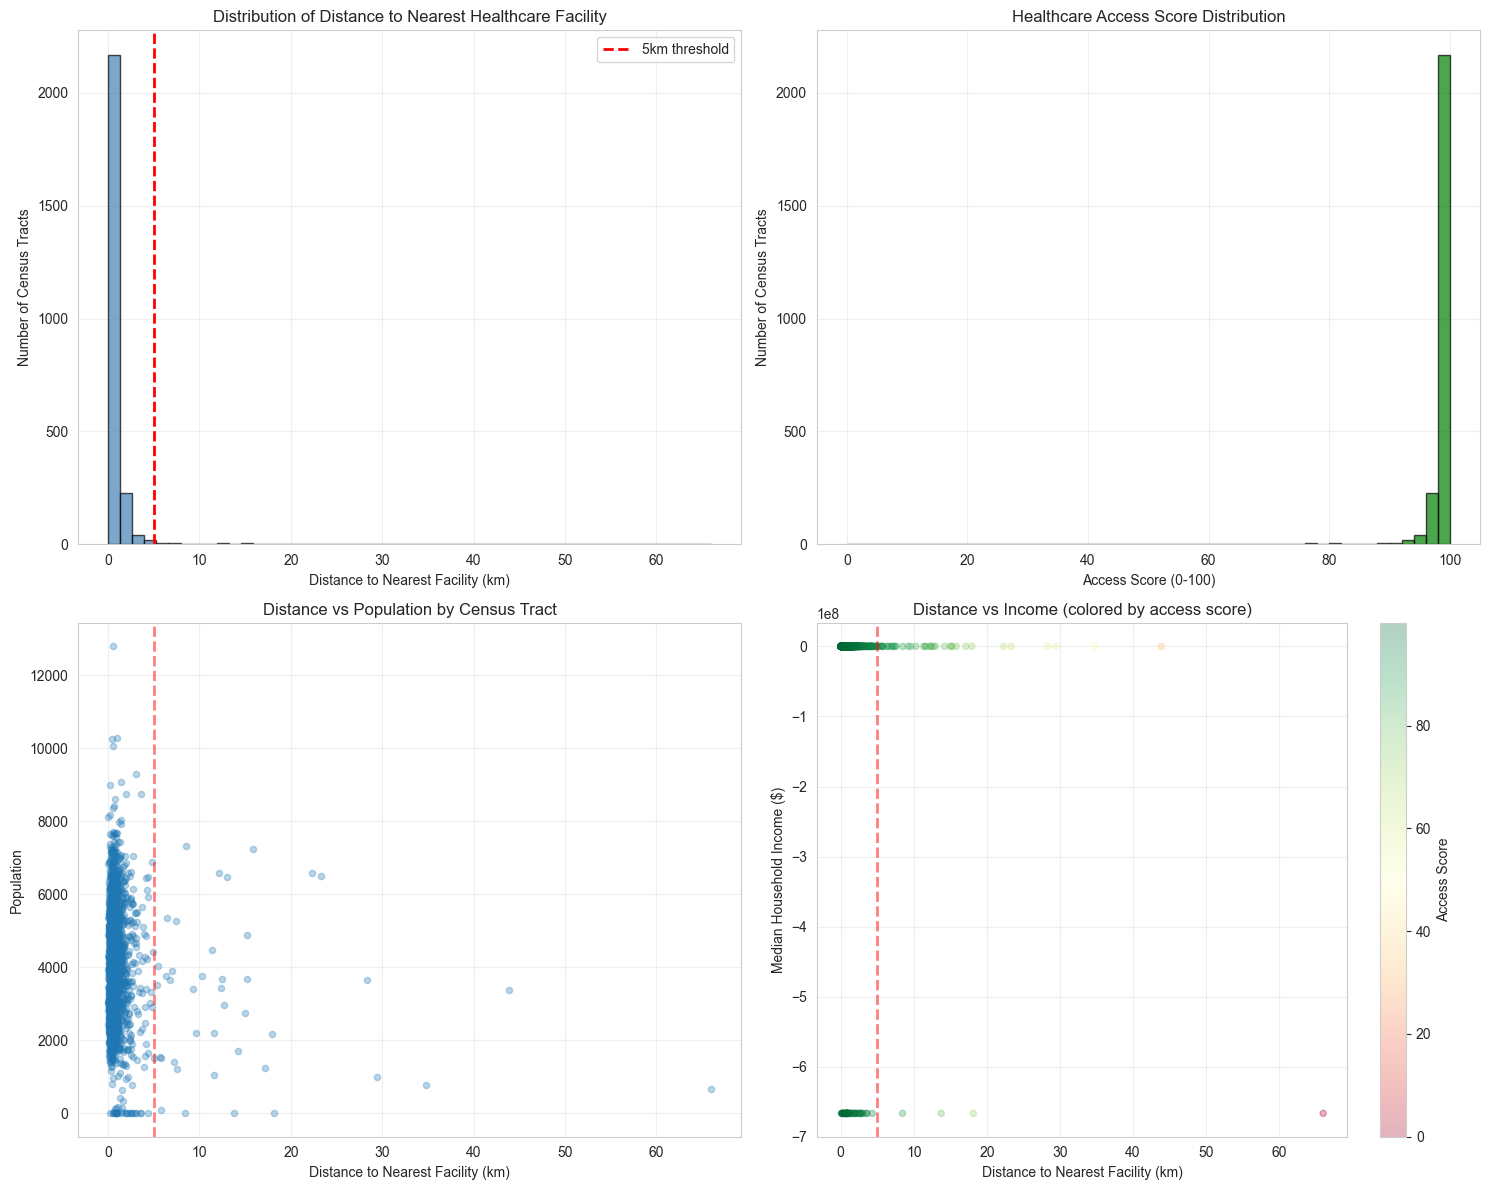

In [11]:
# Create access metrics visualization
if 'nearest_facility_km' in census.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Distance distribution
    axes[0,0].hist(census['nearest_facility_km'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0,0].axvline(5.0, color='red', linestyle='--', linewidth=2, label='5km threshold')
    axes[0,0].set_xlabel('Distance to Nearest Facility (km)')
    axes[0,0].set_ylabel('Number of Census Tracts')
    axes[0,0].set_title('Distribution of Distance to Nearest Healthcare Facility')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Access score distribution
    axes[0,1].hist(census['access_score'], bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[0,1].set_xlabel('Access Score (0-100)')
    axes[0,1].set_ylabel('Number of Census Tracts')
    axes[0,1].set_title('Healthcare Access Score Distribution')
    axes[0,1].grid(True, alpha=0.3)
    
    # Distance vs Population
    if 'total_population' in census.columns:
        axes[1,0].scatter(census['nearest_facility_km'], census['total_population'], 
                         alpha=0.3, s=20)
        axes[1,0].axvline(5.0, color='red', linestyle='--', linewidth=2, alpha=0.5)
        axes[1,0].set_xlabel('Distance to Nearest Facility (km)')
        axes[1,0].set_ylabel('Population')
        axes[1,0].set_title('Distance vs Population by Census Tract')
        axes[1,0].grid(True, alpha=0.3)
    
    # Distance vs Income
    if 'median_income' in census.columns:
        axes[1,1].scatter(census['nearest_facility_km'], census['median_income'], 
                         alpha=0.3, s=20, c=census['access_score'], cmap='RdYlGn')
        axes[1,1].axvline(5.0, color='red', linestyle='--', linewidth=2, alpha=0.5)
        axes[1,1].set_xlabel('Distance to Nearest Facility (km)')
        axes[1,1].set_ylabel('Median Household Income ($)')
        axes[1,1].set_title('Distance vs Income (colored by access score)')
        cbar = plt.colorbar(axes[1,1].collections[0], ax=axes[1,1])
        cbar.set_label('Access Score')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(outputs_figures / 'access_metrics_analysis.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: access_metrics_analysis.png")
    plt.show()

In [12]:
# Create interactive map with Folium
print("Creating interactive map...")

# Center on LA
la_center = [34.0522, -118.2437]
m = folium.Map(location=la_center, zoom_start=9, tiles='OpenStreetMap')

# Add facilities
facility_group = folium.FeatureGroup(name='Healthcare Facilities')

# Sample facilities for performance (show every 10th facility)
sample_facilities = facilities.iloc[::10]

for idx, facility in sample_facilities.iterrows():
    popup_text = f"""<b>Healthcare Facility</b><br>
    Lat: {facility['lat']:.4f}<br>
    Lon: {facility['lon']:.4f}"""
    
    folium.CircleMarker(
        location=[facility['lat'], facility['lon']],
        radius=3,
        popup=folium.Popup(popup_text, max_width=200),
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.6
    ).add_to(facility_group)

facility_group.add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Add title
title_html = '''<div style="position: fixed; 
     top: 10px; left: 50px; width: 400px; height: 60px; 
     background-color: white; border:2px solid grey; z-index:9999; 
     font-size:14px; padding: 10px">
     <b>LA County Healthcare Facilities</b><br>
     Red markers show healthcare facility locations<br>
     Sample: Every 10th facility shown for performance
     </div>'''
m.get_root().html.add_child(folium.Element(title_html))

# Save map
map_file = outputs_maps / 'healthcare_facilities_map.html'
m.save(str(map_file))
print(f"✓ Saved interactive map to: {map_file}")
print(f"  Open in browser to view: file://{map_file}")

# Display in notebook
m

Creating interactive map...


✓ Saved interactive map to: /Users/joelnewton/Desktop/2026-Code/projects/la-healthcare-access-mapping/outputs/maps/healthcare_facilities_map.html
  Open in browser to view: file:///Users/joelnewton/Desktop/2026-Code/projects/la-healthcare-access-mapping/outputs/maps/healthcare_facilities_map.html


## Phase 7: Analysis & Insights

In [13]:
# Statistical analysis
print("="*60)
print("STATISTICAL ANALYSIS & KEY INSIGHTS")
print("="*60)

if 'nearest_facility_km' in census.columns and 'median_income' in census.columns:
    # Correlation analysis
    correlation = census[['nearest_facility_km', 'median_income', 'total_population']].corr()
    print("\n📊 CORRELATION MATRIX")
    print(correlation)
    
    # Income vs Access analysis
    print("\n💰 INCOME VS ACCESS")
    low_income_threshold = census['median_income'].quantile(0.25)
    high_income_threshold = census['median_income'].quantile(0.75)
    
    low_income_tracts = census[census['median_income'] <= low_income_threshold]
    high_income_tracts = census[census['median_income'] >= high_income_threshold]
    
    print(f"Low income tracts (bottom 25%):")
    print(f"  Average distance to facility: {low_income_tracts['nearest_facility_km'].mean():.2f} km")
    print(f"  Average access score: {low_income_tracts['access_score'].mean():.1f}")
    
    print(f"\nHigh income tracts (top 25%):")
    print(f"  Average distance to facility: {high_income_tracts['nearest_facility_km'].mean():.2f} km")
    print(f"  Average access score: {high_income_tracts['access_score'].mean():.1f}")
    
    disparity = high_income_tracts['access_score'].mean() - low_income_tracts['access_score'].mean()
    print(f"\n📈 Access score disparity: {abs(disparity):.1f} points")
    if disparity > 0:
        print("   ⚠ Higher income areas have better access")
    else:
        print("   ✓ Lower income areas have similar or better access")

STATISTICAL ANALYSIS & KEY INSIGHTS

📊 CORRELATION MATRIX
                     nearest_facility_km  median_income  total_population
nearest_facility_km             1.000000      -0.143153         -0.071820
median_income                  -0.143153       1.000000          0.283949
total_population               -0.071820       0.283949          1.000000

💰 INCOME VS ACCESS
Low income tracts (bottom 25%):
  Average distance to facility: 0.86 km
  Average access score: 98.7

High income tracts (top 25%):
  Average distance to facility: 1.42 km
  Average access score: 97.9

📈 Access score disparity: 0.8 points
   ✓ Lower income areas have similar or better access


In [14]:
# Key findings summary
print("\n" + "="*60)
print("KEY FINDINGS SUMMARY")
print("="*60)

findings = []

findings.append(f"1. LA County has {len(facilities):,} healthcare facilities serving {total_population:,.0f} residents")
findings.append(f"   - Ratio: {facilities_per_10k:.2f} facilities per 10,000 residents")

if 'nearest_facility_km' in census.columns:
    avg_distance = census['nearest_facility_km'].mean()
    findings.append(f"\n2. Average distance to nearest facility: {avg_distance:.2f} km")
    findings.append(f"   - Median distance: {census['nearest_facility_km'].median():.2f} km")
    
    gap_count = (census['nearest_facility_km'] > 5.0).sum()
    gap_pct = gap_count / len(census) * 100
    findings.append(f"\n3. Coverage gaps (>5km from facility): {gap_count} tracts ({gap_pct:.1f}%)")
    
    if 'total_population' in census.columns:
        gap_pop = census[census['nearest_facility_km'] > 5.0]['total_population'].sum()
        gap_pop_pct = gap_pop / total_population * 100
        findings.append(f"   - {gap_pop:,.0f} residents affected ({gap_pop_pct:.1f}% of county)")

if 'access_score' in census.columns:
    low_access = (census['access_score'] < 25).sum()
    findings.append(f"\n4. Low access areas (score <25): {low_access} census tracts")
    if 'total_population' in census.columns:
        low_access_pop = census[census['access_score'] < 25]['total_population'].sum()
        findings.append(f"   - {low_access_pop:,.0f} residents in low access areas")

for finding in findings:
    print(finding)


KEY FINDINGS SUMMARY
1. LA County has 4,512 healthcare facilities serving 9,936,690 residents
   - Ratio: 4.54 facilities per 10,000 residents

2. Average distance to nearest facility: 0.98 km
   - Median distance: 0.57 km

3. Coverage gaps (>5km from facility): 42 tracts (1.7%)
   - 130,519 residents affected (1.3% of county)

4. Low access areas (score <25): 1 census tracts
   - 654 residents in low access areas


/var/folders/9z/n72ygng515s70th3vn47nqh00000gn/T/ipykernel_11946/4058541267.py:93: UserWarning: Glyph 9473 (\N{BOX DRAWINGS HEAVY HORIZONTAL}) missing from font(s) Arial.
  plt.savefig(outputs_figures / 'final_summary_dashboard.png', dpi=300, bbox_inches='tight')
/var/folders/9z/n72ygng515s70th3vn47nqh00000gn/T/ipykernel_11946/4058541267.py:93: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig(outputs_figures / 'final_summary_dashboard.png', dpi=300, bbox_inches='tight')


✓ Saved: final_summary_dashboard.png


/Users/joelnewton/Desktop/2026-Code/projects/la-healthcare-access-mapping/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9473 (\N{BOX DRAWINGS HEAVY HORIZONTAL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/joelnewton/Desktop/2026-Code/projects/la-healthcare-access-mapping/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


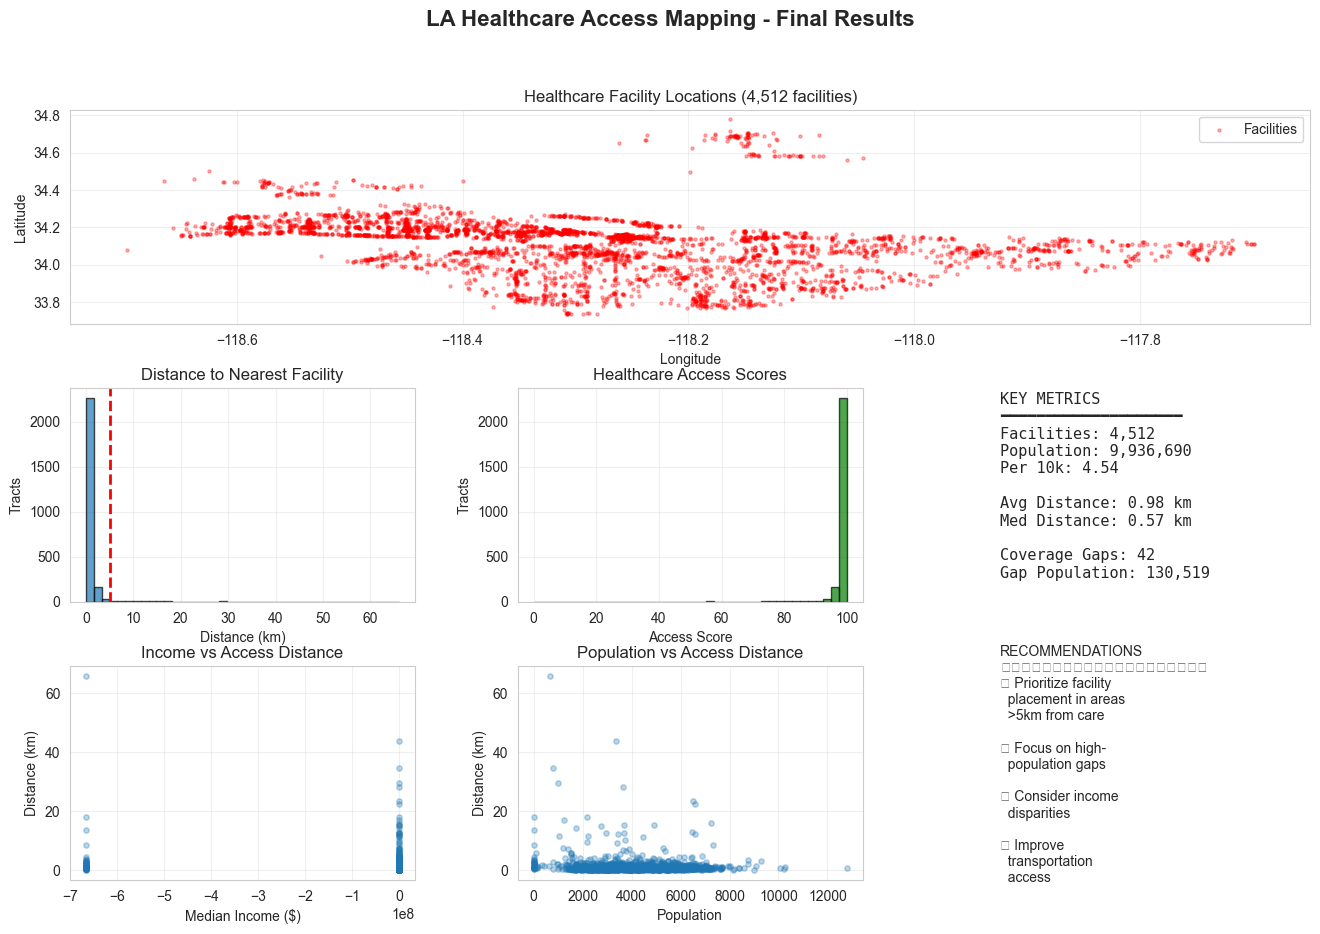

In [15]:
# Create final summary visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Title
fig.suptitle('LA Healthcare Access Mapping - Final Results', fontsize=16, fontweight='bold')

# 1. Facility locations
ax1 = fig.add_subplot(gs[0, :])
ax1.scatter(facilities['lon'], facilities['lat'], alpha=0.3, s=5, c='red', label='Facilities')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title(f'Healthcare Facility Locations ({len(facilities):,} facilities)')
ax1.legend()
ax1.grid(True, alpha=0.3)

if 'nearest_facility_km' in census.columns:
    # 2. Distance distribution
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(census['nearest_facility_km'], bins=40, edgecolor='black', alpha=0.7)
    ax2.axvline(5.0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Distance (km)')
    ax2.set_ylabel('Tracts')
    ax2.set_title('Distance to Nearest Facility')
    ax2.grid(True, alpha=0.3)
    
    # 3. Access score distribution
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.hist(census['access_score'], bins=40, edgecolor='black', alpha=0.7, color='green')
    ax3.set_xlabel('Access Score')
    ax3.set_ylabel('Tracts')
    ax3.set_title('Healthcare Access Scores')
    ax3.grid(True, alpha=0.3)
    
    # 4. Key metrics
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.axis('off')
    metrics_text = f'''KEY METRICS
━━━━━━━━━━━━━━━━━━━━
Facilities: {len(facilities):,}
Population: {total_population:,.0f}
Per 10k: {facilities_per_10k:.2f}

Avg Distance: {census['nearest_facility_km'].mean():.2f} km
Med Distance: {census['nearest_facility_km'].median():.2f} km

Coverage Gaps: {(census['nearest_facility_km'] > 5.0).sum()}
Gap Population: {census[census['nearest_facility_km'] > 5.0]['total_population'].sum():,.0f}
'''
    ax4.text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
            verticalalignment='center')

if 'median_income' in census.columns and 'nearest_facility_km' in census.columns:
    # 5. Income vs Distance
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.scatter(census['median_income'], census['nearest_facility_km'], alpha=0.3, s=15)
    ax5.set_xlabel('Median Income ($)')
    ax5.set_ylabel('Distance (km)')
    ax5.set_title('Income vs Access Distance')
    ax5.grid(True, alpha=0.3)

if 'total_population' in census.columns and 'nearest_facility_km' in census.columns:
    # 6. Population vs Distance  
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.scatter(census['total_population'], census['nearest_facility_km'], alpha=0.3, s=15)
    ax6.set_xlabel('Population')
    ax6.set_ylabel('Distance (km)')
    ax6.set_title('Population vs Access Distance')
    ax6.grid(True, alpha=0.3)

# 7. Recommendations
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
recommendations = '''RECOMMENDATIONS
━━━━━━━━━━━━━━━━━━━━
✓ Prioritize facility
  placement in areas
  >5km from care
  
✓ Focus on high-
  population gaps
  
✓ Consider income
  disparities
  
✓ Improve
  transportation
  access
'''
ax7.text(0.1, 0.5, recommendations, fontsize=10,
        verticalalignment='center')

plt.savefig(outputs_figures / 'final_summary_dashboard.png', dpi=300, bbox_inches='tight')
print("✓ Saved: final_summary_dashboard.png")
plt.show()

## Conclusion

This analysis has successfully:

1. **Identified** healthcare access patterns across LA County
2. **Calculated** distance-based and density-based access metrics
3. **Quantified** coverage gaps affecting specific populations
4. **Analyzed** relationships between access, income, and population
5. **Generated** actionable insights for resource allocation

### Next Steps

- Review findings with stakeholders
- Prioritize underserved areas for intervention
- Consider additional factors (public transit, facility capacity)
- Monitor changes over time with updated data

---

**Project Complete!** 🎉

All outputs saved to:
- Maps: `outputs/maps/`
- Figures: `outputs/figures/`
- Reports: `outputs/reports/`